In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
from regression_dsets_large_names import regression_dsets_large_names
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import fit
from process_results import process_results, aggregate_results, best_ridge

%matplotlib inline
%load_ext autoreload
%autoreload 2

# load results from a directory

In [71]:
!python process_results.py

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


In [72]:
save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)
# parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/df' # basic, pmlb_0, clustered, pmlb_1
parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim' # basic, pmlb_0, clustered, pmlb_1
folders = os.listdir(parent_dir)
print(folders)

['sim1']


# linear plots

5it [00:00, 567.92it/s]
0it [00:00, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
5it [00:00, 80.37it/s]
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecat

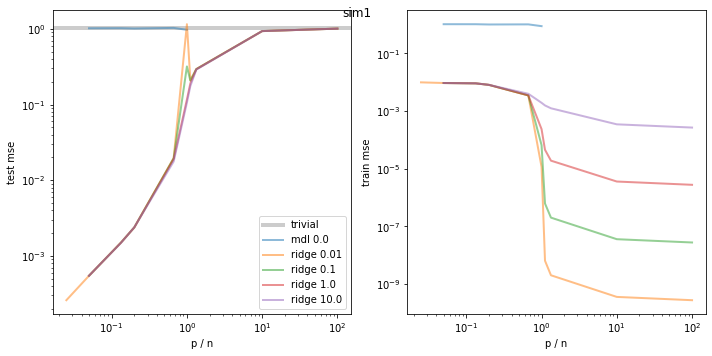

In [73]:
plot_all = False
for folder in folders:
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl'))
    
    row_best_ridge = best_ridge(df) # contains df1, df2, df3
    len_ridge = row_best_ridge.df1.size
    
    if plot_all:
        R, C = 2, 3
    else:
        R, C = 1, 2
    SIZE = 5
    plt.figure(figsize=(C * SIZE, R * SIZE))
    plt.subplot(R, C, 1)
    plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for name, curve in tqdm(df.iterrows()):
    #     print(name, curve)
        model_type = name[3]
        reg_param = name[4]
        l = str(model_type) + ' ' + str(reg_param)
        if model_type == 'ols':
            ls = '--'
        elif model_type == 'ridge':
            ls = '-'
        elif model_type == 'linear_sta':
            ls = '-.'
        elif model_type == 'lasso':
            ls = ':'
        elif model_type == 'mdl':
            ls = '-'
            
        if not model_type == 'linear_sta':


            kwargs = {'label': l, 'alpha': 0.5, 'lw': 2, 'linestyle': ls}

            plt.subplot(R, C, 1)
        #     plt.plot(curve.ratio, curve.mse_test, 
            plt.plot(curve.ratio, curve.mse_noiseless, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
            plt.ylabel('test mse')
            plt.xlabel('p / n')


            plt.subplot(R, C, 2)
            plt.plot(curve.ratio, curve.mse_train, **kwargs)
            plt.ylabel('train mse')
            plt.xlabel('p / n')


            if plot_all:
                plt.subplot(R, C, 4)
                plt.plot(row_best_ridge.df1, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df1: $tr(S S^T)$')

                plt.subplot(R, C, 5)
                plt.plot(row_best_ridge.df2, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df2: $tr(2 * S - S^T S)$')

                plt.subplot(R, C, 6)
                plt.plot(row_best_ridge.df3, curve.mse_noiseless[:len_ridge], **kwargs)
                plt.ylabel('test mse')
                plt.xlabel('df3: $tr(S)$')


            '''
            plt.subplot(R, C, 3)
            plt.plot(curve.ratio, np.square(curve.bias), **kwargs)
            plt.ylabel('bias')

            plt.subplot(R, C, 4)
            plt.plot(curve.ratio, curve['var'], **kwargs)
            plt.ylabel('var')
            '''

            '''
            # wnorm also recorded
            plt.subplot(R, C, 3)
            plt.plot(curve.ratio, curve['wnorm'], **kwargs)
            plt.ylabel('wnorm')
            plt.xlabel('p / n')

            plt.subplot(R, C, 4)
            plt.plot(curve.ratio, curve['num_nonzero'], **kwargs)
            plt.ylabel('num_nonzero')
            plt.xlabel('p / n')
            '''

    for i in range(1, R * C + 1):
        plt.subplot(R, C, i)
        plt.xscale('log')
        plt.yscale('log')

    #     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    plt.subplot(R, C, 1)
    plt.legend()
    
    if plot_all:
        plt.subplot(R, C, 3)
        ratios = row_best_ridge.ratio
        n = 500 / ratios
        p = 0 * ratios + 500
        plt.plot(ratios, np.minimum(n, p), label='min(n, p)', alpha=0.5)
        plt.plot(ratios, row_best_ridge.df1, label='df1')
        plt.plot(ratios, row_best_ridge.df2, label='df2')
        plt.plot(ratios, row_best_ridge.df3, label='df3')
        plt.xlabel('p / n')
        plt.legend()
    
    
    s = folder
    plt.suptitle(s)
    plt.tight_layout()
    # plt.show()
    plt.savefig(oj(save_dir, s + '.pdf'))
    plt.show()
    plt.close()

In [76]:
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim/sim1' # basic, pmlb_0, clustered, pmlb_1
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir)])
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not 'processed' in fname]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 93/93 [00:00<00:00, 555.64it/s]


In [77]:
results.shape

(92, 32)

In [78]:
results.head()

,seed,out_dir,dset,beta_type,beta_norm,iid,dset_num,dset_name,reg_param,num_features,...,w,df1,df2,df3,wnorm,num_nonzero,preds_train,preds_test,train_mse,test_mse
0,0,/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim/sim1,gaussian,gaussian,1,iid,0,,0.01,500,...,"[0.04010736505032683, 0.005127822100358475, -0...",499.994987,500.000000,499.997494,1.001125,500,"[0.64369164238019, 0.48215510208319023, 0.8356...","[-2.0566316537507765, -3.020112227965958, -0.6...",7.921782e-03,0.012115
1,0,/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim/sim1,gaussian,gaussian,1,iid,0,,1.00,500,...,"[0.0027089574380033893, 0.0008826544088102718,...",4.978958,4.999978,4.989468,0.074451,500,"[0.4893057397506824, 0.582040712651717, 1.0168...","[-0.03080230091268323, -0.03051537520873082, -...",2.569554e-06,1.016584
2,0,/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim/sim1,gaussian,gaussian,1,iid,0,,10.00,500,...,"[0.002647832056607362, 0.0008604258317293846, ...",4.795446,4.997851,4.896649,0.072933,500,"[0.4786331242999782, 0.570149858899298, 0.9961...","[-0.030170031383007532, -0.029796829677013886,...",2.465701e-04,1.016583
3,1,/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim/sim1,gaussian,gaussian,1,iid,0,,0.10,500,...,"[0.023376013440371164, 0.007393904320110717, -...",448.209808,449.982144,449.095976,0.985273,500,"[0.8562719071240125, -0.6749775062088441, -0.2...","[-1.9241950002058097, -2.036092084879342, -0.8...",5.716582e-07,0.208125
4,0,/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim/sim1,gaussian,gaussian,1,iid,0,,0.10,500,...,"[0.045354687503244125, 0.0052911949445603205, ...",499.994869,500.000000,499.997435,0.999956,500,"[0.6522148780613268, 0.5284923637016965, 0.830...","[-2.0350706412368105, -2.9561784226903605, -0....",9.700114e-03,0.010194


In [ ]:
results.